In [1]:
!tree -dL 2 input/

input/

0 directories


In [2]:
# generic librairies
import time as time
import numpy as np
import pandas as pd
import gc

# Text librairies
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tag.util import untag
import contractions
# import pycontractions # Alternative better package for removing contractions
from autocorrect import Speller


from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

# Load Data

In [3]:
%%time

# https://numpy.org/devdocs/user/basics.types.html

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'], 
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=10000
                          )

CPU times: user 8.94 ms, sys: 519 µs, total: 9.46 ms
Wall time: 9.81 ms


In [4]:
df_questions

,Id,Score,Body,Title,Text
0,4,718,want use track bar change form opacity code tr...,convert decimal,convert decimal want use track bar change form...
1,6,305,absolutely position div contain child one rela...,width collapse percentage width child element ...,width collapse percentage width child element ...
2,7,479,cast like trans trackbar value identify suffic...,NaN,nan cast like trans trackbar value identify su...
3,9,2008,give datetime represent person age year,calculate someone age base type birthday,calculate someone age base type birthday give ...
4,11,1576,give datetime value display time like hour ago...,calculate time,calculate time give datetime value display tim...
...,...,...,...,...,...
985,2620,1,security expert think fact test security try p...,NaN,nan security expert think fact test security t...
986,2629,0,iis access allow config handle authentication,NaN,nan iis access allow config handle authentication
987,2630,15,find software powershell netcmdlets play love ...,favorite powershell cmdlets,favorite powershell cmdlets find software powe...
988,2639,12,use wordpress blog screwturn two job store com...,web base knowledge base solution,web base knowledge base solution use wordpress...


In [5]:
text_train = df_questions.Text
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

type of text_train: <class 'pandas.core.series.Series'>
length of text_train: 990
text_train[6]:
determine user timezone way web server determine user timezone within page perhaps part agent string


# Representer le texte en "Bag of Words"

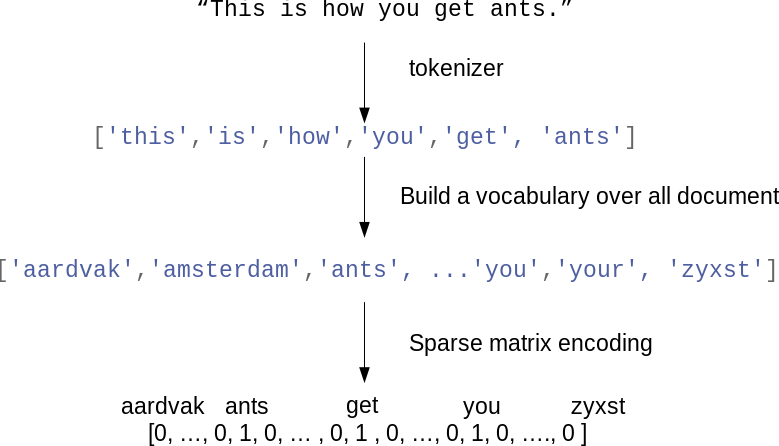

In [6]:
# faire un test de bag of words

bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer()

In [8]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

Vocabulary size: 13
Vocabulary content:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [9]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

bag_of_words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [10]:
print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

Dense representation of bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


## bag-of-words de Post

In [11]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<990x5217 sparse matrix of type '<class 'numpy.int64'>'
	with 30629 stored elements in Compressed Sparse Row format>


In [12]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 5217
First 20 features:
['ab', 'abandon', 'abbreviation', 'abc', 'ability', 'abnormality', 'abrams', 'abs', 'absdiv', 'absolute', 'absolutely', 'abstract', 'abstractbutton', 'abstraction', 'absurd', 'abuse', 'ac', 'accept', 'acceptable', 'acceptance']
Features 5010 to 5030:
['vsize', 'vss', 'vsz', 'wade', 'wadler', 'wafer', 'wait', 'waitforexit', 'waitformultipleobjects', 'walk', 'wall', 'wander', 'want', 'wanted', 'war', 'warmup', 'warn', 'warning', 'warns', 'wart']
Every 2000th feature:
['ab', 'god', 'sale']


## bag-ofword avec plus d'un mot (n-grams)

In [13]:
print("bards_words:\n{}".format(bards_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [14]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [15]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [16]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [17]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: 39
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


# Modélisation automatique des sujets

## LDA, Latent Dirichlet Allocation
L'objectif de ce type de modélisation de sujets est de récupérer de potentielles catégories pour des traitements ultérieurs. Cette modélisation offre surtout une meilleure compréhension de la structuration du texte en vue de création de features manuelles (mettre l'accent sur certains mots, comprendre ce qui définit une catégorie, etc.)


In [18]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                learning_method="online",
                                learning_offset=50.,
                                max_iter=25,
                                random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [20]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 5205)


In [21]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [22]:
#fonction du livre introduction_to_ml_with_python-master

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [23]:
# Print out the 10 topics:

print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
ago           color         mystuffsectionstring        name          
return        round         configuration value         user          
cast          space         somestuff     int           com           
day           value         mystuff       data          application   
minute        math          mystuffelementbyte          form          
datetime      distance      configsection character     http          
month         vector        configurationpropertyname          function      
year          score         configsectionsinput         page          
hour          truncate      section       char          php           
relativetimerangepartition     configurationelementlength        window        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      ---

In [24]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

In [25]:
topics = np.array([2,7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])

In [26]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=8, n_words=10)

topic 2       topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      --------      
fingolfin     label         view          database      column        data          database      cmd           
xfdl          test          model         find          query         dialog        script        conn          
base          set           controller    mysql         could         form          version       dr            
objecttype    px            mvc           performance   table         database      change        difference    
activator     codebase      difference    handle        sql           display       run           colour        
foosolution   integration   print         exception     ccnet         require       schema        vi            
decode        python        presenter     catch         value         age           db          

In [27]:
# sort by weight of "function" topic 36
function = np.argsort(document_topics100[:, 63])[::-1]
# print the five documents where the topic is most important
for i in function[:5]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

custom client side validation custom validation function javascript control net web site check see fee pay excess amount place validator code ascx file also try use page clientscript registerclientscriptblock case validation fire find function output firefox error console feeamountcheck define function take directly view source script type text javascript function feeamountcheck source argument var document getelementbyid ctl footercontentholder fee var amountpaid document getelementbyid ctl footercontentholder fee feepaid value amountpaid argument argument return argument script idea function find remedy without function master page consuming page.

nan way manipulate location hash ajax updates state change would like example page example com client side function execute code ajax code display foo state go location hash foo display browser would updated example com foo allow user bookmark state page use browser history state mechanism place parse hash portion client side use javascrip

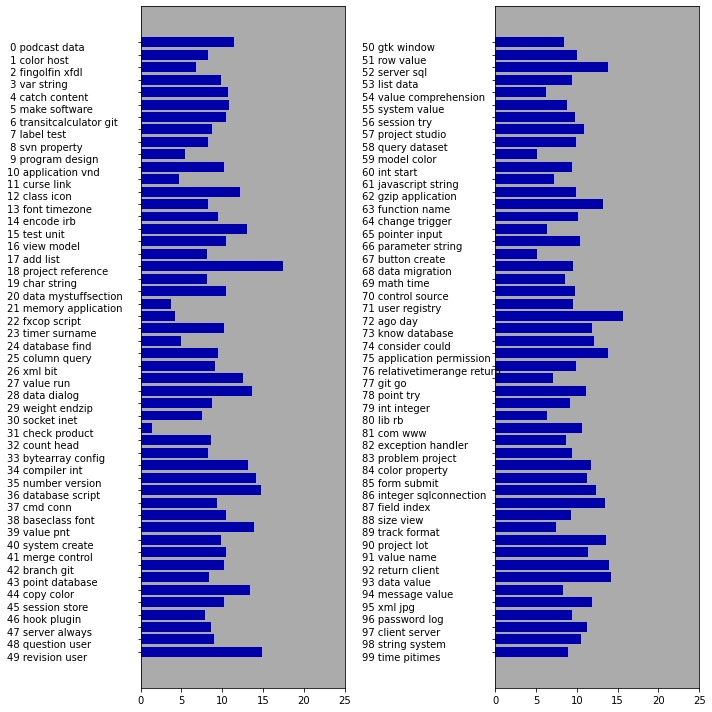

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 25)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')

## NMF - Negative Matrix Factorisation

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

no_top_words = 5
#display_topics(nmf, tfidf_feature_names, no_top_words)

sorting_nmf = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(topics=range(20), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf, topics_per_chunk=8, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       topic 6       topic 7       
--------      --------      --------      --------      --------      --------      --------      --------      


topic 8       topic 9       topic 10      topic 11      topic 12      topic 13      topic 14      topic 15      
--------      --------      --------      --------      --------      --------      --------      --------      


topic 16      topic 17      topic 18      topic 19      
--------      --------      --------      --------      




In [30]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join(
            [feature_names[i] for i in topic.argsort()[::-1][:no_top_words]]))

display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
use nan work like code
Topic 1:
string character char return length
Topic 2:
file copy xml lock process
Topic 3:
test unit integration query nunit
Topic 4:
data mysql structure csv type
Topic 5:
server sql client run password
Topic 6:
database script version table create
Topic 7:
value pass reference pas like
Topic 8:
form field submit input browser
Topic 9:
look article nan run tool
Topic 10:
color distance space apart order
Topic 11:
user session hkey registry application
Topic 12:
com www http slide hello
Topic 13:
memory leak process manage application
Topic 14:
class member seal method structure
Topic 15:
list python comprehension group bar
Topic 16:
chart flash video player embed
Topic 17:
int type integer java object
Topic 18:
project svn branch subversion revision
Topic 19:
view model controller pattern mvc
